In [0]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

# Classification of Partial Differential Equations

일반적인 2차 선형 편미분 방정식 ($u_{xy}=u_{yx}$):
$$Au_{xx} + 2Bu_{xy} + Cu_{yy} + \cdots = 0$$

- $B^2 - AC > 0$: ***Elliptic PDE (ex. Laplace & Poisson equations)***
$$\boxed{\nabla\cdot(k\nabla u) + s = 0}\quad\Longrightarrow\quad \frac{d}{dx}\left(k\frac{du}{dx}\right) + s = 0,\quad\text{1-D}$$

- $B^2 - AC = 0$: ***Parabolic PDE (ex. heat & diffusion equations)***
$$\boxed{\frac{\partial u}{\partial t} = \nabla\cdot(k\nabla u) + s}\quad\Longrightarrow\quad \frac{\partial u}{\partial t} = \frac{d}{dx}\left(k\frac{du}{dx}\right) + s, \quad\text{1-D}$$

- $B^2 - AC < 0$: ***Hyperbolic PDE (ex. wave equations)***
$$\boxed{\frac{\partial^2 u}{\partial t^2} = c^2\nabla^2u}\quad\Longrightarrow\quad \frac{\partial^2 u}{\partial t^2}=c^2\frac{d^2u}{dx^2}, \quad\text{1-D}$$

# Diffusion Equations

$$\boxed{\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2},\quad (x_0\le x\le x_n),\quad u(t_0,x)=u_0(x)}$$
경계조건:
$$\left\{\begin{aligned}
p_0 u(x_0) + u'(x_0) &= r_0, &(x=x_0)\\
p_n u(x_n) + u'(x_n) &= r_n, &(x=x_n)
\end{aligned}\right.$$

**[Example]** 다음 확산 방정식의 해를 구하시오.

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2},\quad u(x,t) = \sqrt{\frac{t_0}{t}}\exp\left(-\frac{x^2}{4kt}\right),\quad k=1,\quad t_0 = 0.1$$

경계조건:
$$u(-5) + u'(-5) = 0,\quad u(5) + u'(5) = 0$$

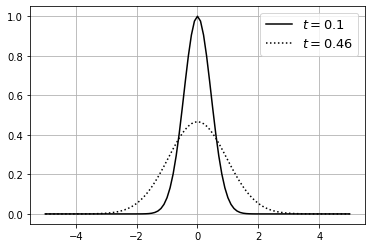

In [2]:
def u_anal(x, t):
    return np.sqrt(t0/t)*np.exp(-x**2/4/k/t)

k, x0, t0 = 1, 5, 0.1
xmin, xmax, xsize = -x0, x0, 101
tmin, tmax, tsize = t0, 1, 101

x, dx = np.linspace(xmin, xmax, xsize, retstep=True)
t, dt = np.linspace(tmin, tmax, tsize, retstep=True)
D = k*dt/dx**2

plt.plot(x, u_anal(x, 0.1), 'k', label="$t=0.1$")
plt.plot(x, u_anal(x, 0.46), 'k:', label="$t=0.46$")
plt.legend(fontsize=13); plt.grid()

## FTCS (Forward in Time Centeral in Space) Scheme

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2},\quad u(x,0) = u_0(x),\quad\begin{cases}u(x_0)+u'(x_0)=0\\ u(x_n)+u'(x_n)=0 \end{cases}$$

시간 $t$에 대해 Forward Difference 그리고 거리 $x$에 대해 Central Difference를 적용하면,
$$\frac{u_i^{k+1} - u_i^k}{\Delta t} = k\frac{u_{i+1}^k - 2u_i^k + u_{i-1}^k}{(\Delta x)^2}$$

$D = k\Delta t/(\Delta x)^2$로 두고 정리하면, $i = 1, 2, \cdots, n-1$일 때,
$$\boxed{u_i^{k+1} = u_i^k + D(u_{i+1}^k -2 u_i^k + u_{i-1}^k)}$$

$x=x_0 (i = 0)$일 때, 경계조건과 비교하면,
$$u_0^{k+1} = Du_{-1}^k + (1-2D) u_0^k + Du_{1}^k,\quad u_0 + \frac{u_1 - u_{-1}}{2\Delta x} = 0$$

$u_{-1}$항을 소거하고 정리하면,
$$\boxed{u_0^{k+1} = (1-2D+2D\Delta x) u_0^k + 2Du_{1}^k}$$

$x=x_n (i = n)$일 때, 경계조건과 비교하면,
$$u_n^{k+1} = Du_{n-1}^k + (1-2D) u_n^k + Du_{n+1}^k,\quad u_n + \frac{u_{n+1} - u_{n-1}}{2\Delta x} = 0$$

$u_{n+1}$항을 소거하고 정리하면,
$$\boxed{u_n^{k+1} = 2Du_{n-1} + (1 - 2D - 2D\Delta x) u_n^k}$$

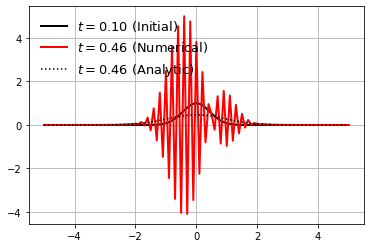

In [3]:
# FTCS Scheme
def update(u, dx, D):
    u_i = u[1:-1] + D*np.diff(u, 2)
    u_0 = (1 - 2*D + 2*D*dx)*u[0] + 2*D*u[1]
    u_n = 2*D*u[-2] + (1 - 2*D - 2*D*dx)*u[-1]

    return np.r_[u_0, u_i, u_n]

u = np.r_[[u_anal(x, t0)]*tsize]
for n in range(tsize-1):
    u[n+1] = update(u[n], dx, D)

n = 40
plt.plot(x, u[0], 'k', lw=2, label="$t=%.2f$ (Initial)" % t[0])
plt.plot(x, u[n], 'r', lw=2, label="$t=%.2f$ (Numerical)" % t[n])
plt.plot(x, u_anal(x, t[n]), 'k:', label="$t=%.2f$ (Analytic)" % t[n])
plt.legend(fontsize=13, loc="upper left", frameon=False); plt.grid()

## Richardson Scheme (1910)

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2},\quad u(x,0) = u_0(x),\quad\begin{cases}u(x_0)+u'(x_0)=0\\ u(x_n)+u'(x_n)=0 \end{cases}$$

시간 $t$에 대해 Central Difference 그리고 거리 $x$에 대해 Central Difference를 적용하면,
$$\frac{u_i^{k+1} - u_i^{k-1}}{2\Delta t} = k\frac{u_{i+1}^k - 2u_i^k + u_{i-1}^k}{(\Delta x)^2}$$

$D = k\Delta t/(\Delta x)^2$로 두고 정리하면, $i = 1, 2, \cdots, n-1$일 때,
$$\boxed{u_i^{k+1} = u_i^{k-1} + 2D(u_{i+1}^k -2u_i^k + u_{i-1}^k)}$$

$x=x_0 (i = 0)$일 때, 경계조건과 비교하면,
$$u_0^{k+1} = u_0^{k-1} + 2D(u_{-1}^k -2u_0^k + u_{1}^k),\quad u_0 + \frac{u_1 - u_{-1}}{2\Delta x} = 0$$

$u_{-1}$항을 소거하고 정리하면,
$$\boxed{u_0^{k+1} = u_0^{k-1} -4D(1-\Delta x) u_0^k + 4Du_{1}^k}$$

$x=x_n (i = n)$일 때, 경계조건과 비교하면,
$$u_n^{k+1} = u_n^{k-1} + 2D(u_{n-1}^k -2u_n^k + u_{n+1}^k),\quad u_n + \frac{u_{n+1} - u_{n-1}}{2\Delta x} = 0$$

$u_{n+1}$항을 소거하고 정리하면,
$$\boxed{u_n^{k+1} = u_n^{k-1} + 4Du_{n-1}^k - 4D(1 + \Delta x) u_n^k}$$

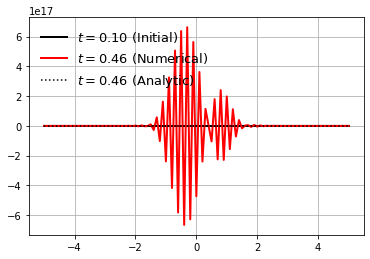

In [4]:
# Richardson Scheme
def update(u0, u1, dx, D):
    u_i = u0[1:-1] + 2*D*np.diff(u1, 2)
    u_0 = u0[0] - 4*D*(1 - dx)*u1[0] + 4*D*u1[1]
    u_n = u0[-1] + 4*D*u1[-2] - 4*D*(1 + dx)*u1[-1]

    return np.r_[u_0, u_i, u_n]

u = np.r_[[u_anal(x, t0)]*tsize]
for n in range(tsize-2):
    u[n+2] = update(u[n], u[n+1], dx, D)

n = 40
plt.plot(x, u[0], 'k', lw=2, label="$t=%.2f$ (Initial)" % t[0])
plt.plot(x, u[n], 'r', lw=2, label="$t=%.2f$ (Numerical)" % t[n])
plt.plot(x, u_anal(x, t[n]), 'k:', label="$t=%.2f$ (Analytic)" % t[n])
plt.legend(fontsize=13, loc="upper left", frameon=False); plt.grid()

## DuFort-Frankel Scheme (1953)

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2},\quad u(x,0) = u_0(x),\quad\begin{cases}u(x_0)+u'(x_0)=0\\ u(x_n)+u'(x_n)=0 \end{cases}$$

시간 $t$에 대해 Central Difference 그리고 거리 $x$에 대해 Central Difference를 적용하면,
$$\frac{u_i^{k+1} - u_i^{k-1}}{2\Delta t} = k\frac{u_{i+1}^k - 2u_i^k + u_{i-1}^k}{(\Delta x)^2},\quad u_i^k = \frac{u_i^{k+1} + u_i^{k-1}}{2}$$

$D = k\Delta t/(\Delta x)^2$로 두고 정리하면, $i = 1, 2, \cdots, n-1$일 때,
$$\boxed{u_i^{k+1} = \frac{1}{1+2D}\Bigl[(1-2D)u_i^{k-1} + 2Du_{i-1}^k + 2Du_{i+1}^k)\Bigl]}$$

$x=x_0 (i = 0)$일 때, 경계조건과 비교하면,
$$u_0^{k+1} = \frac{1}{1+2D}\Bigl[(1-2D)u_0^{k-1} + 2Du_{-1}^k + 2Du_{1}^k)\Bigl],\quad u_0 + \frac{u_1^k - u_{-1}^k}{2\Delta x} = 0$$

$u_{-1}$항을 소거하고 정리하면,
$$\boxed{u_0^{k+1} = \frac{1}{1+2D}\Bigl[(1-2D)u_0^{k-1} + 4Dhu_0^k + 4Du_{1}^k\Bigl]}$$

$x=x_n (i = n)$일 때, 경계조건과 비교하면,
$$u_n^{k+1} = \frac{1}{1+2D}\Bigl[(1-2D)u_n^{k-1} + 2Du_{n-1}^k + 2Du_{n+1}^k)\Bigl],\quad u_n + \frac{u_{n+1}^k - u_{n-1}^k}{2\Delta x} = 0$$

$u_{n+1}$항을 소거하고 정리하면,
$$\boxed{u_n^{k+1} = \frac{1}{1+2D}\Bigl[(1-2D)u_n^{k-1} + 4Du_{n-1}^k - 4Dhu_n^k\Bigl]}$$

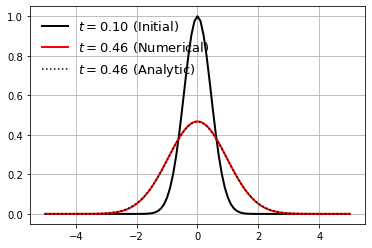

In [5]:
# DuFort-Frankel scheme
def update(u0, u1, dx, D):
    u_i = ((1 - 2*D)*u0[1:-1] + 2*D*u1[:-2] + 2*D*u1[2:])/(1 + 2*D)
    u_0 = ((1 - 2*D)*u0[0] + 4*D*dx*u1[0] + 4*D*u1[1])/(1 + 2*D)
    u_n = ((1 - 2*D)*u0[-1] + 2*D*u1[-2] - 4*D*dx*u1[-1])/(1 + 2*D)

    return np.r_[u_0, u_i, u_n]   

u = np.r_[[u_anal(x, t0)]*tsize]
for n in range(tsize-2):
    u[n+2] = update(u[n], u[n+1], dx, D)

n = 40
plt.plot(x, u[0], 'k', lw=2, label="$t=%.2f$ (Initial)" % t[0])
plt.plot(x, u[n], 'r', lw=2, label="$t=%.2f$ (Numerical)" % t[n])
plt.plot(x, u_anal(x, t[n]), 'k:', label="$t=%.2f$ (Analytic)" % t[n])
plt.legend(fontsize=13, loc="upper left", frameon=False); plt.grid()

## Crank-Nicolson Scheme (1947)

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2},\quad u(x,0) = u_0(x),\quad\begin{cases}u(x_0)+u'(x_0)=0\\ u(x_n)+u'(x_n)=0 \end{cases}$$

시간 $t$에 대해 Central Difference 그리고 거리 $x$에 대해 Central Difference를 적용하면,
$$\frac{u_i^{k+1} - u_i^{k}}{\Delta t} = \frac{k}{2}\frac{u_{i+1}^{k+1} - 2u_i^{k+1} + u_{i-1}^{k+1}}{(\Delta x)^2} + \frac{k}{2}\frac{u_{i+1}^k - 2u_i^k + u_{i-1}^k}{(\Delta x)^2}$$

$D = k\Delta t/(\Delta x)^2$로 두고 정리하면, $i = 1, 2, \cdots, n-1$일 때,
$$\boxed{-\frac{D}{2}u_{i-1}^{k+1} + (1+D)u_i^{k+1} -\frac{D}{2}u_{i+1}^{k+1} = 
\frac{D}{2}u_{i-1}^{k} + (1-D)u_i^{k} +\frac{D}{2}u_{i+1}^{k}}$$

$x=x_0 (i = 0)$일 때, 경계조건과 비교하면,
$$-\frac{D}{2}u_{-1}^{k+1} + (1+D)u_0^{k+1} -\frac{D}{2}u_{1}^{k+1} = 
\frac{D}{2}u_{-1}^{k} + (1-D)u_0^{k} +\frac{D}{2}u_{1}^{k},\quad u_0 + \frac{u_1^k - u_{-1}^k}{2\Delta x} = 0$$

$u_{-1}$항을 소거하고 정리하면,
$$\boxed{(1+D-D\Delta x)u_0^{k+1} - Du_{1}^{k+1} = (1-D+D\Delta x)u_0^{k} + Du_{1}^{k}}$$

$x=x_n (i = n)$일 때, 경계조건과 비교하면,
$$-\frac{D}{2}u_{n-1}^{k+1} + (1+D)u_n^{k+1} -\frac{D}{2}u_{n+1}^{k+1} = 
\frac{D}{2}u_{n-1}^{k} + (1-D)u_n^{k} +\frac{D}{2}u_{n+1}^{k},\quad u_n + \frac{u_{n+1}^k - u_{n-1}^k}{2\Delta x} = 0$$

$u_{n+1}$항을 소거하고 정리하면,
$$\boxed{- Du_{n-1}^{k+1} + (1+D+D\Delta x)u_n^{k+1} = Du_{n-1}^{k} + (1-D-D\Delta x)u_0^{k}}$$

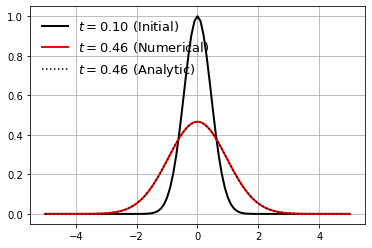

In [6]:
# Crank-Nicolson scheme
def update(u, dx, D):
    ai = np.full(u.size-2, -D/2)
    bi = np.full(u.size-2, 1 + D)
    ci = np.full(u.size-2, -D/2)
    di = 0.5*D*u[:-2] + (1 - D)*u[1:-1] + 0.5*D*u[2:]

    # Boundary conditions:
    b0, c0 = 1 + D - D*dx, -D
    an, bn = -D, 1 + D + D*dx
    d0 = (1 - D + D*dx)*u[0] + D*u[1]
    dn = D*u[-2] + (1 - D - D*dx)*u[0]

    diags = np.r_[ai, an, 0], np.r_[b0, bi, bn], np.r_[0, c0, ci]
    mat = spdiags(diags, [-1,0,1], u.size, u.size, format="csr")
    rhs = np.r_[d0, di, dn]

    return spsolve(mat, rhs)

u = np.r_[[u_anal(x, t0)]*tsize]
for n in range(tsize-1):
    u[n+1] = update(u[n], dx, D)

n = 40
plt.plot(x, u[0], 'k', lw=2, label="$t=%.2f$ (Initial)" % t[0])
plt.plot(x, u[n], 'r', lw=2, label="$t=%.2f$ (Numerical)" % t[n])
plt.plot(x, u_anal(x, t[n]), 'k:', label="$t=%.2f$ (Analytic)" % t[n])
plt.legend(fontsize=13, loc="upper left", frameon=False); plt.grid()

## Laasonen Scheme (1949)

일반적으로 $\theta$에 대해 ($\theta$-scheme)
$$u_i^{k+1} = u_i^k + \theta D(u_{i-1}^{k+1} -2u_i^{k+1} + u_{i+1}^{k+1}) + (1-\theta)D(u_{i-1}^k -2u_i^k + u_{i+1}^k)$$

- $\theta = 0$: Explicit, FTCS scheme

- $\theta = 1$: Implicit, Laasonen-scheme (1949)

- $\theta = 0.5$: Crank-Nicolson scheme

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2},\quad u(x,0) = u_0(x),\quad\begin{cases}u(x_0)+u'(x_0)=0\\ u(x_n)+u'(x_n)=0 \end{cases}$$

시간 $t$에 대해 Central Difference 그리고 거리 $x$에 대해 Central Difference를 적용하면,
$$u_i^{k+1} = u_i^k + D(u_{i-1}^{k+1} -2u_i^{k+1} + u_{i+1}^{k+1})$$

$D = k\Delta t/(\Delta x)^2$로 두고 정리하면, $i = 1, 2, \cdots, n-1$일 때,
$$\boxed{-Du_{i-1}^{k+1} + (1+2D)u_i^{k+1} -Du_{i+1}^{k+1} = u_i^k}$$

$x=x_0 (i = 0)$일 때, 경계조건과 비교하면,
$$-Du_{-1}^{k+1} + (1+2D)u_0^{k+1} -Du_{1}^{k+1} = u_i^k,\quad u_0 + \frac{u_1^k - u_{-1}^k}{2\Delta x} = 0$$

$u_{-1}$항을 소거하고 정리하면,
$$\boxed{(1+2D-2D\Delta x)u_0^{k+1} - 2Du_{1}^{k+1} = u_0^k}$$

$x=x_n (i = n)$일 때, 경계조건과 비교하면,
$$-Du_{n-1}^{k+1} + (1+2D)u_n^{k+1} -Du_{n+1}^{k+1} = u_i^k,\quad u_n + \frac{u_{n+1}^k - u_{n-1}^k}{2\Delta x} = 0$$

$u_{n+1}$항을 소거하고 정리하면,
$$\boxed{- 2Du_{n-1}^{k+1} + (1+2D+2D\Delta x)u_n^{k+1} = u_n^k}$$

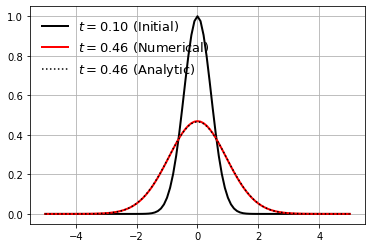

In [7]:
# Laasonen scheme (f = 1)
def update(u, dx, D):
    ai = np.full(u.size-2, -D)
    bi = np.full(u.size-2, 1 + 2*D)
    ci = np.full(u.size-2, -D)
    di = u[1:-1]

    # Boundary conditions:
    b0, c0 = 1 + 2*D - 2*D*dx, -2*D
    an, bn = -2*D, 1 + 2*D + 2*D*dx
    d0, dn = u[0], u[-1]

    diags = np.r_[ai, an, 0], np.r_[b0, bi, bn], np.r_[0, c0, ci]
    mat = spdiags(diags, [-1,0,1], u.size, u.size, format="csr")
    rhs = np.r_[d0, di, dn]

    return spsolve(mat, rhs)

u = np.r_[[u_anal(x, t0)]*tsize]
for n in range(tsize-1):
    u[n+1] = update(u[n], dx, D)

n = 40
plt.plot(x, u[0], 'k', lw=2, label="$t=%.2f$ (Initial)" % t[0])
plt.plot(x, u[n], 'r', lw=2, label="$t=%.2f$ (Numerical)" % t[n])
plt.plot(x, u_anal(x, t[n]), 'k:', label="$t=%.2f$ (Analytic)" % t[n])
plt.legend(fontsize=13, loc="upper left", frameon=False); plt.grid()

## Method of Lines

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2},\quad u(x,0) = u_0(x)$$

$i=1,2,\cdots,n-1$일 때, central difference를 적용하면,
$$\boxed{\frac{du_i}{dt} = k\frac{u_{i+1} -2u_i + u_{i+1}}{h^2}}$$

$i = 0$일 때,
$$\frac{du_0}{dt} = k\frac{u_{1} -2u_0 + u_{-1}}{h^2},\quad
u_0 + \frac{u_1 - u_{-1}}{2h} = 0$$

$u_{-1}$항을 소거하고 정리하면,
$$\boxed{\frac{du_0}{dt} = \frac{2k}{h^2}\Bigl[-(1-h)u_0 + u_1\Bigl]}$$

$i = n$일 때,
$$\frac{du_n}{dt} = k\frac{u_{n+1} -2u_n + u_{n-1}}{h^2},\quad
u_n + \frac{u_{n+1} - u_{n-1}}{2h} = 0$$

$u_{n+1}$항을 소거하고 정리하면,
$$\boxed{\frac{du_n}{dt} = \frac{2k}{h^2}\Bigl[u_{n-1} - (1+h)u_n\Bigl]}$$

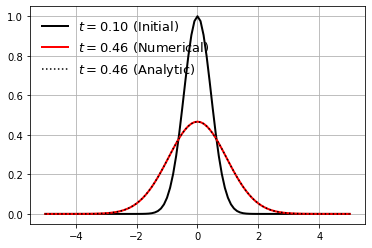

In [8]:
# Method of lines for diffusion eqn:
def diffusion(u, t, h, k):
    dudt = np.empty_like(u)
    dudt[0] = 2*k*(-(1 - h)*u[0] + u[1])/h**2
    dudt[1:-1] = k*np.diff(u, 2)/h**2
    dudt[-1] = 2*k*(u[-2] - (1 + h)*u[-1])/h**2

    return dudt

u0 = u_anal(x, t0)
u = odeint(diffusion, u0, t, args=(dx, k), ml=1, mu=1)

n = 40
plt.plot(x, u[0], 'k', lw=2, label="$t=%.2f$ (Initial)" % t[0])
plt.plot(x, u[n], 'r', lw=2, label="$t=%.2f$ (Numerical)" % t[n])
plt.plot(x, u_anal(x, t[n]), 'k:', label="$t=%.2f$ (Analytic)" % t[n])
plt.legend(fontsize=13, loc="upper left", frameon=False); plt.grid()

# Wave and Advection Equations

시간, 공간의 함수 $u(x,t)$에 대한 1차원 파동방정식, ($v$는 속도)
$$\boxed{\frac{\partial^2u}{\partial t} = v^2 \frac{\partial^2 u}{\partial x^2}}$$

일반해는 임의의 함수 $f$, $g$에 대해 다음과 같이 주어진다.
$$u(x, t) = f(x-vt) + g(x+vt)$$

새로운 변수 $\nu = \partial\xi/\partial t$와 $\theta=-c\partial\xi/\partial x$를 정의해서 2개의 1차 미분 방정식으로 바꿀수 있다.

$$\frac{\partial\nu}{\partial t} + v\frac{\partial\theta}{\partial x} = 0,\quad \frac{\partial\theta}{\partial t} + v\frac{\partial\nu}{\partial x} = 0$$

또는 입자의 농도 또는 파동 $u(x, t)$가 대류에 의해 변화하면,
$$u(x, t+\Delta t) = u(x-v\Delta t, t)$$

$\Delta t$의 크기가 충분히 작다면, Taylor 전개를 통해,
$$u(x, t) + \Delta t \frac{\partial u}{\partial t} \simeq u(x, t) - v\Delta t \frac{\partial u}{\partial x}\quad\Rightarrow\quad \boxed{\frac{\partial u}{\partial t} + v\frac{\partial u}{\partial x} = 0}$$

$D = v\Delta t/\Delta x$의 값은 CFL 수(Courant–Friedrichs–Lewy Number)로 불리며 파동 방정식의 수치적 안정성을 평가하는데 사용된다.

In [0]:
def plot_results(ax, x, u, title=""):
    ax.plot(x, u[0], 'k:', lw=2, label="$t=0$")
    ax.plot(x, u[10], 'r', lw=2, label="$t=%.f$" % t[10])
    ax.plot(x, u[20], 'g', lw=2, label="$t=%.f$" % t[20])
    ax.plot(x, u[30], 'b', lw=2, label="$t=%.f$" % t[30])
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=12, loc="upper right", frameon=False)
    ax.grid()

tmin, tmax, tsize = 0, 3, 31
xmin, xmax, xsize = 0, 1, 101
t, dt = np.linspace(tmin, tmax, tsize, retstep=True)
x, dx = np.linspace(xmin, xmax, xsize, retstep=True)

## FTCS (Forward in Time Centeral in Space) Scheme

$$\frac{\partial u}{\partial t} + v\frac{\partial u}{\partial x} = 0,\quad u(x,0) = u_0(x),\quad u(x_0, t) = u(x_n, t)$$

시간 $t$에 대해 Forward Difference 그리고 거리 $x$에 대해 Central Difference를 적용하면,
$$\frac{u_i^{k+1} - u_i^k}{\Delta t} + v\frac{u_{i+1}^k - u_{i-1}^k}{2\Delta x} = 0$$

$D = v\Delta t/\Delta x$로 두고 정리하면, $i = 1, 2, \cdots, n-1$일 때,
$$\boxed{u_i^{k+1} = u_i^k - \frac{D}{2}u_{i+1}^k + \frac{D}{2} u_{i-1}^k}$$

$i = 0$일 때,
$$u_0^{k+1} = u_0^k - \frac{D}{2}u_1^k + \frac{D}{2}u_{-1}^k,\quad
u_{-1}^k = u_n^k$$

$u_{-1}$항을 소거하고 정리하면,
$$\boxed{u_0^{k+1} = u_0^k - \frac{D}{2}u_1^k + \frac{D}{2}u_n^k}$$

$i = n$일 때,
$$u_n^{k+1} = u_n^k - \frac{D}{2}u_{n+1}^k + \frac{D}{2} u_{n-1}^k,\quad
u_{n+1}^k  = u_0^k$$

$u_{n+1}$항을 소거하고 정리하면,
$$\boxed{u_n^{k+1} = u_n^k - \frac{D}{2}u_0^k + \frac{D}{2} u_{n-1}^k}$$

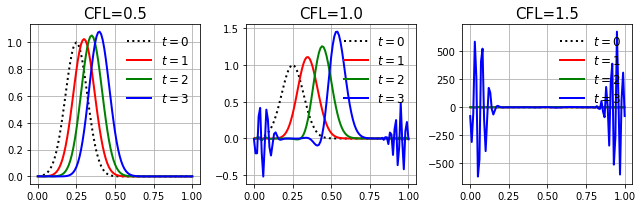

In [10]:
# FTCS scheme:
def update(u, cfl):
    ui = u[1:-1] - cfl*u[2:]/2 + cfl*u[:-2]/2
    u0 = u[0] - cfl*u[1]/2 + cfl*u[-1]/2
    un = u[-1] - cfl*u[0]/2 + cfl*u[-2]
    return np.r_[u0, ui, u0]

u0 = np.exp(-100*(x-0.25)**2)
u1 = np.r_[[u0]*tsize]
u2 = np.r_[[u0]*tsize]
u3 = np.r_[[u0]*tsize]
for n in range(tsize-1):
    u1[n+1] = update(u1[n], cfl=0.5)
    u2[n+1] = update(u2[n], cfl=1.0)
    u3[n+1] = update(u3[n], cfl=1.5)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
plot_results(ax1, x, u1, title="CFL=0.5")
plot_results(ax2, x, u2, title="CFL=1.0")
plot_results(ax3, x, u3, title="CFL=1.5")
fig.tight_layout()

## Lax-Friedrich Scheme

$$\frac{\partial u}{\partial t} + v\frac{\partial u}{\partial x} = 0,\quad u(x,0) = u_0(x),\quad u(x_0, t) = u(x_n, t)$$

시간 $t$에 대해 Forward Difference 그리고 거리 $x$에 대해 Central Difference를 적용하면,
$$\frac{u_i^{k+1} - u_i^k}{\Delta t} + v\frac{u_{i+1}^k - u_{i-1}^k}{2\Delta x} = 0, \quad u_i^k = \frac{u_{i+1}^k + u_{i-1}^k}{2}$$

$D = v\Delta t/\Delta x$로 두고 정리하면, $i = 1, 2, \cdots, n-1$일 때,
$$\boxed{u_i^{k+1} = \frac{1+D}{2}u_{i-1}^k + \frac{1-D}{2}u_{i+1}^k}$$

$i = 0$일 때,
$$u_0^{k+1} = \frac{1+D}{2}u_{-1}^k + \frac{1-D}{2}u_{1}^k,\quad
u_{-1}^k = u_n^k$$

$u_{-1}$항을 소거하고 정리하면,
$$\boxed{u_0^{k+1} = \frac{1+D}{2}u_n^k + \frac{1-D}{2}u_{1}^k}$$

$i = n$일 때,
$$u_n^{k+1} = \frac{1+D}{2}u_{n-1}^k + \frac{1-D}{2}u_{n+1}^k,\quad
u_{n+1}^k  = u_0^k$$

$u_{n+1}$항을 소거하고 정리하면,
$$\boxed{u_n^{k+1} = \frac{1+D}{2}u_{n-1}^k + \frac{1-D}{2}u_0^k}$$

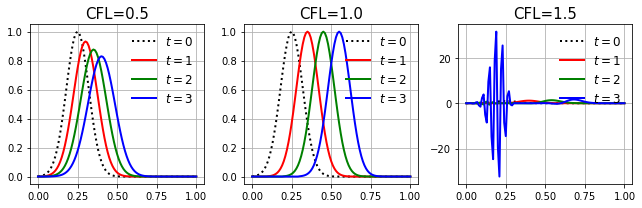

In [11]:
# Lax-Friedrich scheme:
def update(u, cfl):
    ui = (1 + cfl)*u[:-2]/2 + (1 - cfl)*u[2:]/2
    u0 = (1 + cfl)*u[-1]/2 + (1 - cfl)*u[1]/2
    un = (1 + cfl)*u[-2]/2 + (1 - cfl)*u[0]/2
    return np.r_[u0, ui, un]

u0 = np.exp(-100*(x-0.25)**2)
u1 = np.r_[[u0]*tsize]
u2 = np.r_[[u0]*tsize]
u3 = np.r_[[u0]*tsize]
for n in range(tsize-1):
    u1[n+1] = update(u1[n], cfl=0.5)
    u2[n+1] = update(u2[n], cfl=1.0)
    u3[n+1] = update(u3[n], cfl=1.5)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
plot_results(ax1, x, u1, title="CFL=0.5")
plot_results(ax2, x, u2, title="CFL=1.0")
plot_results(ax3, x, u3, title="CFL=1.5")
fig.tight_layout()

## Lax-Wendroff Scheme

$$\frac{\partial u}{\partial t} + v\frac{\partial u}{\partial x} = 0,\quad u(x,0) = u_0(x),\quad u(x_0, t) = u(x_n, t)$$

시간 $t$에 대해 Taylor 전개를 하면,
$$u_i^{k+1} = u_i^k + \Delta t \left(\frac{\partial u}{\partial t}\right)_i^k + \frac{(\Delta t)^2}{2}\left(\frac{\partial^2 u}{\partial t^2}\right)_i^k + \cdots$$

Advection equation으로부터,
\begin{align*}
\left(\frac{\partial u}{\partial t}\right)_i^k &= -v\left(\frac{\partial u}{\partial x}\right)_i^n \simeq -v\frac{u_{i+1}^k - u_{i-1}^k}{2\Delta x} \\
\left(\frac{\partial^2 u}{\partial t^2}\right)_i^k &= -v^2\left(\frac{\partial^2 u}{\partial x^2}\right)_i^n \simeq -v^2\frac{u_{i+1}^k -2u_i^k + u_{i-1}^k}{(\Delta x)^2}
\end{align*}

$D = v\Delta t/\Delta x$로 두고 정리하면, $i = 1, 2, \cdots, n-1$일 때,
$$\boxed{u_i^{k+1} = u_i^k - \frac{D}{2}(u_{i+1}^k - u_{i-1}^k) + \frac{D^2}{2}(u_{i+1}^k -2u_i^k + u_{i-1}^k)}$$

$i = 0$일 때,
$$u_0^{k+1} = u_0^k - \frac{D}{2}(u_{1}^k - u_{-1}^k) + \frac{D^2}{2}(u_{1}^k -2u_0^k + u_{-1}^k),\quad u_{-1}^k = u_n^k$$

$u_{-1}$항을 소거하고 정리하면,
$$\boxed{u_0^{k+1} = u_0^k - \frac{D}{2}(u_{1}^k - u_{n}^k) + \frac{D^2}{2}(u_{1}^k -2u_0^k + u_{n}^k)}$$

$i = n$일 때,
$$u_n^{k+1} = u_n^k - \frac{D}{2}(u_{n+1}^k - u_{n-1}^k) + \frac{D^2}{2}(u_{n+1}^k -2u_n^k + u_{n-1}^k),\quad u_{n+1}^k  = u_0^k$$

$u_{n+1}$항을 소거하고 정리하면,
$$\boxed{u_n^{k+1} = u_n^k - \frac{D}{2}(u_{0}^k - u_{n-1}^k) + \frac{D^2}{2}(u_{0}^k -2u_n^k + u_{n-1}^k)}$$

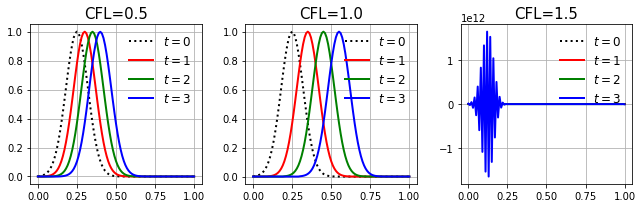

In [12]:
# Lax-Wendroff scheme:
def update(u, cfl):
    ui = u[1:-1] - cfl*(u[2:]-u[:-2])/2 + cfl**2*np.diff(u,2)/2
    u0 = u[0] - cfl*(u[1]-u[-1])/2 + cfl**2*(u[1] - 2*u[0] + u[-1])/2
    un = u[-1] - cfl*(u[0]-u[-2])/2 + cfl**2*(u[0] - 2*u[-1] + u[-2])/2
    return np.r_[u0, ui, un]

u0 = np.exp(-100*(x-0.25)**2)
u1 = np.r_[[u0]*tsize]
u2 = np.r_[[u0]*tsize]
u3 = np.r_[[u0]*tsize]
for n in range(tsize-1):
    u1[n+1] = update(u1[n], cfl=0.5)
    u2[n+1] = update(u2[n], cfl=1.0)
    u3[n+1] = update(u3[n], cfl=1.5)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
plot_results(ax1, x, u1, title="CFL=0.5")
plot_results(ax2, x, u2, title="CFL=1.0")
plot_results(ax3, x, u3, title="CFL=1.5")
fig.tight_layout()

## Crank-Nicholson Scheme

$$\frac{\partial u}{\partial t} + v\frac{\partial u}{\partial x} = 0,\quad u(x,0) = u_0(x),\quad u(x_0, t) = u(x_n, t)$$

$D = v\Delta t/\Delta x$로 두고 정리하면, $i = 1, 2, \cdots, n-1$일 때,
$$\boxed{u_i^{k+1} + \frac{D}{4}(u_{i+1}^{k+1} - u_{i-1}^{k+1}) = u_i^k - \frac{D}{4}(u_{i+1}^k - u_{i-1}^k)}$$

$i = 0$일 때,
$$u_0^{k+1} + \frac{D}{4}(u_{1}^{k+1} - u_{-1}^{k+1}) = u_0^k - \frac{D}{4}(u_{1}^k - u_{-1}^k),\quad u_{-1}^{k+1} = u_n^{k+1},\quad u_{-1}^k = u_n^k$$

$u_{-1}$항을 소거하고 정리하면,
$$\boxed{u_0^{k+1} + \frac{D}{4}(u_{1}^{k+1} - u_{n}^{k+1}) = u_0^k - \frac{D}{4}(u_{1}^k - u_{n}^k)}$$

$i = n$일 때,
$$u_n^{k+1} + \frac{D}{4}(u_{n+1}^{k+1} - u_{n-1}^{k+1}) = u_n^k - \frac{D}{4}(u_{n+1}^k - u_{n-1}^k),\quad u_{n+1}^{k+1}  = u_0^{k+1},\quad u_{n+1}^k  = u_0^k$$

$u_{n+1}$항을 소거하고 정리하면,
$$\boxed{u_n^{k+1} + \frac{D}{4}(u_{0}^{k+1} - u_{n-1}^{k+1}) = u_n^k - \frac{D}{4}(u_{0}^k - u_{n-1}^k)}$$

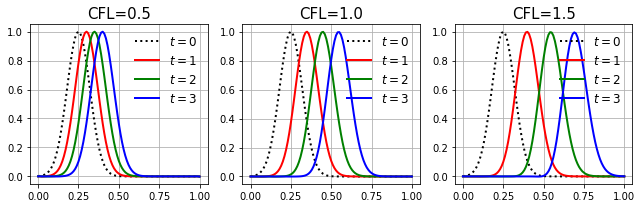

In [13]:
# Crank-Nicholson Scheme:
def update(u, cfl):
    ai = np.full(u.size-2, -0.25*cfl)
    bi = np.full(u.size-2, 1)
    ci = np.full(u.size-2,  0.25*cfl)
    di = u[1:-1] - cfl*(u[2:] - u[:-2])/4
    
    # Boundary conditions:
    b0, c0 = 1, 0.25*D
    an, bn = -0.25*D, 1
    d0 = u[0] - 0.25*D*(u[1] - u[-1]), 
    dn = u[-1] - 0.25*D*(u[0] - u[-2])

    diags = np.r_[ai, an, 0], np.r_[b0, bi, bn], np.r_[0, c0, ci]
    mat = spdiags(diags, [-1,0,1], u.size, u.size, format="lil")
    mat[0,-1] = -0.25*D
    mat[-1, 0] = 0.25*D
    rhs = np.r_[d0, di, dn]

    return spsolve(mat.tocsr(), rhs)

u0 = np.exp(-100*(x-0.25)**2)
u1 = np.r_[[u0]*tsize]
u2 = np.r_[[u0]*tsize]
u3 = np.r_[[u0]*tsize]
for n in range(tsize-1):
    u1[n+1] = update(u1[n], cfl=0.5)
    u2[n+1] = update(u2[n], cfl=1.0)
    u3[n+1] = update(u3[n], cfl=1.5)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
plot_results(ax1, x, u1, title="CFL=0.5")
plot_results(ax2, x, u2, title="CFL=1.0")
plot_results(ax3, x, u3, title="CFL=1.5")
fig.tight_layout()

## Method of Lines

$$\frac{\partial u}{\partial t} + v\frac{\partial u}{\partial x} = 0,\quad u(x,0) = u_0(x),\quad u(x_0, t) = u(x_n, t)$$

$i=1,2,\cdots,n-1$일 때, central difference를 적용하면,
$$\boxed{\frac{du_i}{dt} = -v\frac{u_{i+1} - u_{i-1}}{2h}}$$

$i = 0$일 때, 
$$\frac{du_0}{dt} = -v\frac{u_1 - u_{-1}}{2h},\quad
u_0 + \frac{u_1 - u_{-1}}{2h} = 0$$

$i = n$일 때, 
$$\frac{du_n}{dt} = -v\frac{u_{n+1} - u_{n-1}}{2h},\quad
u_n + \frac{u_{n+1} - u_{n-1}}{2h} = 0$$

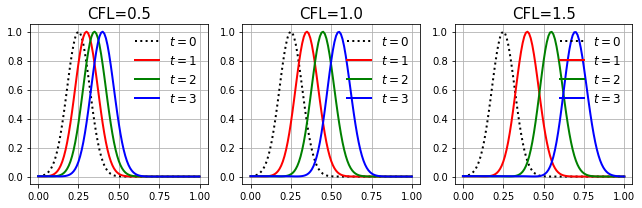

In [14]:
# Method of lines for advection eqn:
def advection(u, t, h, v):
    dudt = np.empty_like(u)
    dudt[0] = v*u[0]
    dudt[1:-1] = -v*(u[2:] - u[:-2])/2/h
    dudt[-1] = v*u[-1]

    return dudt

u0 = np.exp(-100*(x-0.25)**2)
u1 = odeint(advection, u0, t, args=(dx, 0.05))
u2 = odeint(advection, u0, t, args=(dx, 0.1))
u3 = odeint(advection, u0, t, args=(dx, 0.15))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
plot_results(ax1, x, u1, title="CFL=0.5")
plot_results(ax2, x, u2, title="CFL=1.0")
plot_results(ax3, x, u3, title="CFL=1.5")
fig.tight_layout()

# Nonlinear Advection Equations

일반적으로 $f(u) \neq vu$ 형태가 아닌 Nonlinear 형태일 때는 Multi-step 방법으로 확장한다.
$$\frac{\partial u}{\partial t} + \frac{\partial f}{\partial x} = 0$$

## Ricthmyer Two Step Lax-Wendroff Scheme

**[Step-1]**
\begin{align*}
u_{i+1/2}^{k+1/2} &= \frac{1}{2}(u_i^k + u_{i+1}^k) - \frac{\Delta t}{2\Delta x}\left(f(u_{i+1}^n) - f(u_i^k)\right) \\
u_{i-1/2}^{k+1/2} &= \frac{1}{2}(u_{i-1}^k + u_{i}^k) - \frac{\Delta t}{2\Delta x}\left(f(u_i^k) - f(u_{i-1}^k)\right)
\end{align*}

**[Step-2]**
$$u_i^{k+1} = u_i^k - \frac{\Delta t}{\Delta x}\left(f(u_{i+1/2}^{k+1/2}) - f(u_{i-1/2}^{k+1/2})\right)$$

$f(u) = vu$ 선형이면, 1-Step Lax-Wendroff Scheme과 일치한다.

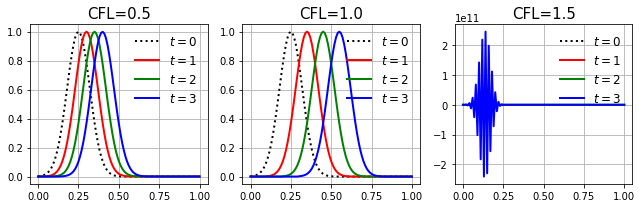

In [15]:
# Ricthmyer 2-step Lax-Wendroff scheme: for linear f(u) = v u
def f(u, v): return v*u    # Linear advection
def g(u, v): return v*u**2 # Nonlinear advection

def update(u, cfl):
    u1 = (u[1:-1] + u[2:])/2 - cfl*(u[2:] - u[1:-1])/2
    u2 = (u[:-2] + u[1:-1])/2 - cfl*(u[1:-1] - u[:-2])/2
    u_new = u[1:-1] - cfl*(u1 - u2)
    return np.r_[0, u_new, 0]

u0 = np.exp(-100*(x-0.25)**2)
u1 = np.r_[[u0]*tsize]
u2 = np.r_[[u0]*tsize]
u3 = np.r_[[u0]*tsize]
for n in range(tsize-1):
    u1[n+1] = update(u1[n], cfl=0.5)
    u2[n+1] = update(u2[n], cfl=1.0)
    u3[n+1] = update(u3[n], cfl=1.5)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
plot_results(ax1, x, u1, title="CFL=0.5")
plot_results(ax2, x, u2, title="CFL=1.0")
plot_results(ax3, x, u3, title="CFL=1.5")
fig.tight_layout()

## MacCormack Scheme

**[Step-1]**
$$u_i^p = u_i^k + \frac{\Delta t}{\Delta x}\left(f(u_i^k) - f(u_{i+1}^k)\right)$$

**[Step-2]**
$$u_i^{k+1} = \frac{1}{2}(u_i^k + u_i^p) + \frac{\Delta t}{2\Delta x}\left(f(u_{i-1}^p) - f(u_i^p)\right)$$

$f(u) = vu$ 선형이면, 1-Step Lax-Wendroff Scheme과 일치한다.

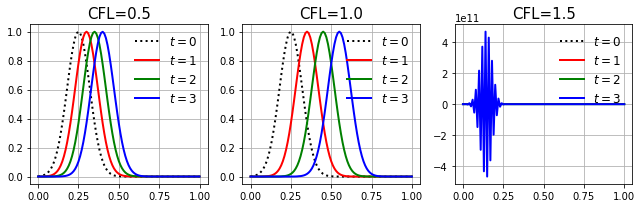

In [16]:
# MacCormack scheme: for linear f(u) = v u
def update(u, cfl):
    up = u.copy()
    up[1:-1] = u[1:-1] + cfl*(u[1:-1] - u[2:])
    u_new = (u[1:-1] + up[1:-1])/2 + cfl*(up[:-2] - up[1:-1])/2
    return np.r_[0, u_new, 0]

u0 = np.exp(-100*(x-0.25)**2)
u1 = np.r_[[u0]*tsize]
u2 = np.r_[[u0]*tsize]
u3 = np.r_[[u0]*tsize]
for n in range(tsize-1):
    u1[n+1] = update(u1[n], cfl=0.5)
    u2[n+1] = update(u2[n], cfl=1.0)
    u3[n+1] = update(u3[n], cfl=1.5)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
plot_results(ax1, x, u1, title="CFL=0.5")
plot_results(ax2, x, u2, title="CFL=1.0")
plot_results(ax3, x, u3, title="CFL=1.5")
fig.tight_layout()

# Diffusion with Convection

$$\boxed{\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2} + v\frac{\partial u}{\partial x},\quad (x_0\le x\le x_n),\quad u(t_0,x)=u_0(x)}$$
경계조건:
$$\left\{\begin{aligned}
p_0 u(x_0) + u'(x_0) &= r_0, &(x=x_0)\\
p_n u(x_n) + u'(x_n) &= r_n, &(x=x_n)
\end{aligned}\right.$$

## Mason-Weaver Equation

침강과 확산이 동시에 일어날 때, 시간에 따른 위치별 농도 $c(t, z)$ 다음 편미분 방정식을 따른다.
$$\boxed{\frac{\partial c}{\partial t} = D\frac{\partial^2 c}{\partial z^2} + sg\frac{\partial c}{\partial z},\quad (0\le z\le z_{\text{max}})}$$

경계조건은 다음과 같다.
$$\boxed{D\frac{\partial c}{\partial z} + sgc=0\,\quad(z=0,\, z=z_{\text{max}})}$$

- 확산계수 $D$
- 침강계수 $s$, 중력가속도 $g$, 침강속도 $v=sg$

참고자료:

1. Johanna Midelet, Afaf El-Sagheer, Tom Brown, Antonios Kanaras, Martinus H. V. Werts. ***The sedimentation of colloidal nanoparticles in solution and its study using quantitative digital photography. Particle and Particle Systems Characterization***, Wiley-VCH Verlag, 2017, 34 (10), pp.1700095. 10.1002/ppsc.201700095. hal-01637907

1. [Mason Weaver Equation (Wikipedia)](https://en.wikipedia.org/wiki/Mason%E2%80%93Weaver_equation)

## Dimensionless Mason-Weaver Equation

무차원 농도 $u = c/c_0$, 무차원 거리 $\zeta= z/z_0$와 무치원 시간 $\tau= t/t_0$를 다음과 같이 정의한다.
$$z_0 = \frac{D}{sg},\quad t_0 = \frac{D}{s^2g^2}\quad\Longrightarrow\quad
\boxed{\frac{\partial u}{\partial\tau} = \frac{\partial^2u}{\partial\zeta^2} + \frac{\partial u}{\partial\zeta},\quad(0<\zeta<1)}$$

Crank-Nicolson Method를 이용해 차분화하면
\begin{align*}
\frac{\partial u}{\partial\tau} &\simeq \frac{u_i^{k+1}-u_i^{k}}{\tau_{k+1}-\tau_k} \\
\frac{\partial^2 u}{\partial\zeta^2} &\simeq \frac{1}{2}\left[\frac{u_{i+1}^{k+1} -2u_i^{k+1} + u_{i-1}^{k+1}}{(\Delta\zeta)^2} + \frac{u_{i+1}^k -2u_i^k + u_{i-1}^k}{(\Delta\zeta)^2}\right] \\
\frac{\partial u}{\partial\zeta} &\simeq \frac{1}{2}\left[\frac{u_{i+1}^{k+1} - u_{i-1}^{k+1}}{2\Delta\zeta} + \frac{u_{i+1}^k - u_{i-1}^k}{2\Delta\zeta}\right]
\end{align*}

변수 $\alpha$, $\beta$, $\gamma$를 정의하여 정리한다.
$$\alpha=\frac{1}{2(\Delta\zeta)^2},\quad \beta=\frac{1}{4\Delta\zeta},\quad \gamma=\frac{1}{\tau_{k+1} - \tau_k}$$

$$\boxed{(-\alpha+\beta)u_{i-1}^{k+1} + (2\alpha+\gamma)u_{i}^{k+1} + (-\alpha-\beta)u_{i+1}^{k+1} = (\alpha-\beta)u_{i-1}^{k} + (-2\alpha+\gamma)u_{i}^{k} + (\alpha+\beta)u_{i+1}^{k}}$$

Tridiagonal 행렬식 $(i = 1, 2, \cdots, n-1)$:
$$a_i u_{i-1}^{k+1} + b_i u_i^{k+1} + c_i u_{i+1}^{k+1} = d_i$$
여기서,
\begin{align*}
a_i = -\alpha+\beta,\quad
b_i = 2\alpha+\gamma,\quad
c_i = -\alpha-\beta\\
d_i = (\alpha-\beta)u_{i-1}^{k} + (-2\alpha+\gamma)u_{i}^{k} + (\alpha+\beta)u_{i+1}^{k}
\end{align*}

## Dimensionless Mixed Boundary Conditons

$$\boxed{\frac{\partial u}{\partial\zeta} + u = 0,\quad (\zeta=0,\,\zeta=1)}$$

$\zeta=0\, (i=0)$에서 Forward Difference와 Crank-Nicolson Method를 이용해 차분화 하면
\begin{align*}
u &\simeq \frac{1}{2}\left[\frac{u_1^{k+1}+u_0^{k+1}}{2} + \frac{u_1^{k}+u_0^{k}}{2}\right] = \frac{1}{4}(u_1^{k+1}+u_0^{k+1} + u_1^{k}+u_0^{k})\\
\frac{\partial u}{\partial\zeta} &\simeq \frac{1}{2}\left[\frac{u_1^{k+1}-u_0^{k+1}}{\Delta\zeta} + \frac{u_1^{k}-u_0^{k}}{\Delta\zeta}\right]
= 2\beta(u_1^{k+1}-u_0^{k+1} + u_1^{k}-u_0^{k})
\end{align*}

정리하면,
$$\boxed{\left(-2\beta+\frac{1}{4}\right)u_{0}^{k+1} + \left(2\beta+\frac{1}{4}\right)u_{1}^{k+1} = \left(2\beta-\frac{1}{4}\right)u_{0}^{k} + \left(-2\beta-\frac{1}{4}\right)u_{1}^{k}}$$

Tridiagonal 행렬식의 첫번째 행을 다음과 같이 수정한다.
$$b_0 u_0^{k+1} + c_0 u_1^{k+1} = d_0$$
여기서,
$$b_0 = -2\beta+\frac{1}{4},\quad c_0 = 2\beta+\frac{1}{4},\quad d_0 = \left(2\beta-\frac{1}{4}\right)u_{0}^{k} + \left(-2\beta-\frac{1}{4}\right)u_{1}^{k}$$

$\zeta=1\,(i=n)$에서 Backward Difference와 Crank-Nicolson Method를 이용해 차분화 하면
\begin{align*}
c &\simeq \frac{1}{2}\left[\frac{u_{n}^{k+1}+u_{n-1}^{k+1}}{2} + \frac{u_{n}^{k}+u_{n-1}^{k}}{2}\right] = \frac{1}{4}(u_{n}^{k+1}+u_{n-1}^{k+1} + u_{n}^{k}+u_{n-1}^{k})\\
\frac{\partial u}{\partial\zeta} &\simeq \frac{1}{2}\left[\frac{u_{n}^{n+1}-u_{n-1}^{k+1}}{\Delta\zeta} + \frac{u_{n}^{k}-u_{n-1}^{k}}{\Delta\zeta}\right]
= 2\beta(u_{n}^{k+1}-u_{n-1}^{k+1} + u_{n}^{k}-u_{n-1}^{k})
\end{align*}

정리하면,
$$\boxed{\left(-2\beta+\frac{1}{4}\right)u_{n-1}^{k+1} + \left(2\beta+\frac{1}{4}\right)u_{n}^{k+1} = \left(2\beta-\frac{1}{4}\right)u_{n-1}^{k} + \left(-2\beta-\frac{1}{4}\right)u_{n}^{k}}$$

Tridiagonal 행렬식의 마지 행을 다음과 같이 수정한다.
$$a_n u_{n-1}^{k+1} + b_n u_n^{k+1} = d_n$$
여기서,
$$a_n = -2\beta+\frac{1}{4},\quad b_n = 2\beta+\frac{1}{4},\quad d_n = \left(2\beta-\frac{1}{4}\right)u_{n-1}^{k} + \left(-2\beta-\frac{1}{4}\right)u_{n}^{k}$$

In [0]:
def sedimentation(time, mesh, diff, vel, c0, tsize=101):
    z0, t0 = diff/vel, diff/vel**2
    tau = pow(time/t0+1, np.arange(tsize)/(tsize-1)) - 1
    zeta, zsize = mesh/z0, mesh.size
    h = zeta[1]-zeta[0]

    c = np.full((tsize, zsize), c0, dtype=float)
    for k in range(tsize-1):
        alpha, beta, gamma = 0.5/h**2, 0.25/h, 1/(tau[k+1]-tau[k])

        # LHS tridiagonal matrix & BC's
        ai = np.full(zsize,  -alpha + beta)
        bi = np.full(zsize, 2*alpha + gamma)
        ci = np.full(zsize,  -alpha - beta)
        di = (alpha - beta)*c[k][:-2] + (-2*alpha+gamma)*c[k][1:-1] \
           + (alpha + beta)*c[k][2:]

        mat = spdiags((ai, bi, ci), [-1, 0, 1], zsize, zsize, format='lil')
        mat[0, :2]   = -2*beta + 0.25, 2*beta + 0.25
        mat[-1, -2:] = -2*beta + 0.25, 2*beta + 0.25

        rhs = np.r_[0, di, 0]
        rhs[0]  = (2*beta - 0.25)*c[k][0]  + (-2*beta - 0.25)*c[k][1]
        rhs[-1] = (2*beta - 0.25)*c[k][-2] + (-2*beta - 0.25)*c[k][-1]

        c[k+1] = spsolve(mat.tocsr(), rhs)

    return c[-1]

**[Example] Normalized Sedimentation with Diffusion**

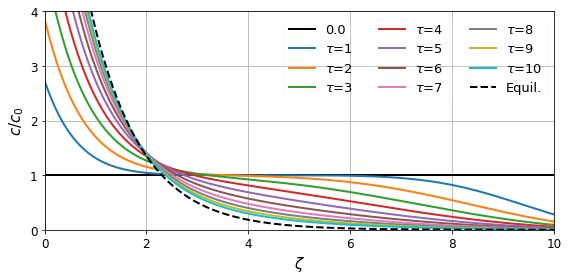

In [18]:
# Input parameters:
diff, vel, c0 = 1.0, 1.0, 1.0
mesh = np.linspace(0, 10, 1001)
time = np.linspace(1, 10, 10)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(mesh, np.ones_like(mesh)*c0, 'k-', lw=2, label='0.0')
for t in time:
    c = sedimentation(t, mesh, diff, vel, c0)
    ax.plot(mesh, c, lw=2, label=r'$\tau$=%.f' % t)

zmax, zmin, z0 = mesh.max(), mesh.min(), diff/vel
B = ((zmax-zmin)/z0)/(1-np.exp(-(zmax-zmin)/z0))
ax.plot(mesh, B*np.exp(-(mesh-zmin)/z0), 'k--', lw=2, label='Equil.')

ax.set_xlim(zmin, zmax)
ax.set_ylim(0, 4); ax.set_yticks([0, 1, 2, 3, 4])
ax.set_xlabel(r'$\zeta$', fontsize=15, weight='bold')
ax.set_ylabel('$c/c_0$', fontsize=15, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(ncol=3, fontsize=13, framealpha=0.1); ax.grid()
fig.tight_layout()

**[Example] Simulation of Sedimentation with Diffusion**

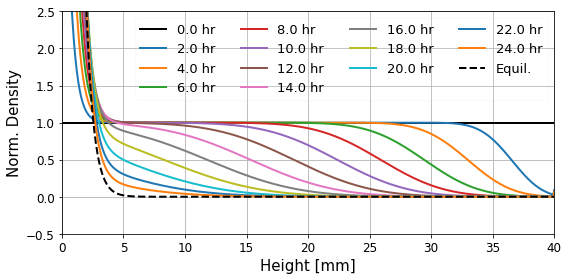

In [19]:
from scipy.constants import g, milli, day, hour

# Input parameters:
diff, vel, c0 = 3e-10, 5e-8*g, 1.0
mesh = np.linspace(0*milli, 40*milli, 1001)
time = np.linspace(1/12., 1.0, 12)*day

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(mesh/milli, np.ones_like(mesh)*c0, 'k-', lw=2, label='0.0 hr')
for t in time:
    c = sedimentation(t, mesh, diff, vel, c0)
    ax.plot(mesh/milli, c, lw=2, label='%.1f hr' % (t/hour))

zmax, zmin, z0 = mesh.max(), mesh.min(), diff/vel
B = ((zmax-zmin)/z0)/(1-np.exp(-(zmax-zmin)/z0))
ax.plot(mesh/milli, B*np.exp(-(mesh-zmin)/z0), 'k--', lw=2, label='Equil.')

ax.set_xlim(zmin/milli, zmax/milli)
ax.set_ylim(-0.5, 2.5)
ax.set_xlabel('Height [mm]', fontsize=15)
ax.set_ylabel('Norm. Density', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(ncol=4, fontsize=13, framealpha=0.1); ax.grid()
fig.tight_layout()

## Method of Lines

$$\frac{\partial u}{\partial t} = D\frac{\partial^2 u}{\partial x^2} + v\frac{\partial u}{\partial x},\quad(0<x<L)$$
경계조건:
$$vu + D\frac{\partial u}{\partial x} = 0,\quad(x=0, x=L)$$

$i=1,2,\cdots,n-1$에 대해, central difference를 적용하면,
$$\boxed{\frac{du_i}{dt} = D\frac{u_{i+1} -2u_i + u_{i-1}}{h^2} + v\frac{u_{i+1} - u_{i-1}}{2h}}$$

$i=0$일 때, 경계조건과 비교하면
$$\frac{du_0}{dt} = D\frac{u_1 -2u_0 + u_{-1}}{h^2} + v\frac{u_1 - u_{-1}}{2h},\quad vu_0 + D\frac{u_1-u_{-1}}{2h} = 0$$

$u_{-1}$ 항을 소거하여 정리하면,
$$\boxed{\frac{du_0}{dt} = \frac{2}{h^2}\Bigl[(vh-D)u_0 -Du_1\Bigl] - \frac{v^2}{D}u_0}$$

$i=n$일 때, 경계조건과 비교하면
$$\frac{du_n}{dt} = D\frac{u_{n+1} -2u_{n} + u_{n-1}}{h^2} + v\frac{u_{n+1} - u_{n-1}}{2h},\quad vu_n + D\frac{u_{n+1}-u_{n-1}}{2h} = 0$$

$u_{n+1}$ 항을 소거하여 정리하면,
$$\boxed{\frac{du_n}{dt} = \frac{2}{h^2}\Bigl[Du_{n-1} - (vh+D)u_n\Bigl] - \frac{v^2}{D}u_n}$$

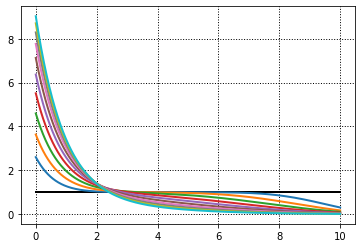

In [21]:
# Method of lines for Mason-Weaver eqn: 
from scipy.integrate import odeint

def mason_weaver(u, t, dx, D=1, v=1):
    dudt = np.empty_like(u)
    dudt[0] = 2*((v*dx - D)*u[0] + D*u[1])/dx**2 - v**2*u[0]/D
    dudt[1:-1] = D*np.diff(u, 2)/dx**2 + v*(u[2:] - u[:-2])/2/dx
    dudt[-1] = 2*(D*u[-2]- (v*dx + D)*u[-1])/dx**2 - v**2*u[-1]/D

    return dudt

x, dx = np.linspace(0, 10, 1001, retstep=True)
t = np.linspace(1, 10, 11)
u0 = c0*np.ones_like(x)
u = odeint(mason_weaver, u0, t, args=(dx,), ml=1, mu=1)

plt.plot(x, u[0], 'k', lw=2)
for k in range(t.size-1):
    plt.plot(x, u[k+1], lw=2)
plt.grid(c='k', ls=':', lw=1)

# Coupled Diffusion with Reaction

## 1-D Gray-Scott equations

$x_0=0$와 $x_n=L$일 때, $N+1$ mesh $\{x_0, x_1,\cdots,x_{n-1},x_n\}$에 대해,
\begin{align*}
\frac{\partial u}{\partial t} &= D_u\frac{\partial^2 u}{\partial x^2} - uv^2 + f(1-u)\\
\frac{\partial v}{\partial t} &= D_v\frac{\partial^2 v}{\partial x^2} + uv^2 - (f + k)v
\end{align*}

Neumann 경계조건:
$$\frac{\partial u}{\partial x}(0,t) = 0,\quad \frac{\partial v}{\partial x}(0,t) = 0,\quad \frac{\partial u}{\partial x}(L,t) = 0,\quad \frac{\partial v}{\partial x}(L,t) = 0,\quad$$

## Discretizaiton

A system of $2(N+1)$ ordinary differential equations ($i=1,2,\cdots,n-1$),
\begin{align*}
\frac{du_i}{dt} & = D_u\frac{u_{i-1}-2u_i+u_{i+1}}{h^2} - u_iv_i^2 + f(1-u_i)\\
\frac{dv_i}{dt} & = D_v\frac{v_{i-1}-2v_i+u_{i+1}}{h^2} + u_iv_i^2 - (f+k)v_i
\end{align*}

$i=0$일 때, Neumann 경계조건을 적용하면
\begin{align*}
\frac{du_0}{dt} & = D_u\frac{u_1 -2u_0+u_{-1}}{h^2} - u_0v_0^2 + f(1-u_0), 
& \frac{\partial u}{\partial x} = \frac{u_1 - u_{-1}}{2h} = 0\\
\frac{dv_0}{dt} & = D_v\frac{v_1 -2v_0+u_{-1}}{h^2} + u_0v_0^2 - (f+k)v_0, 
& \frac{\partial v}{\partial x} = \frac{v_1 - v_{-1}}{2h} = 0
\end{align*}

$u_{-1}$과 $v_{-1}$을 소거하 정리하면,
\begin{align*}
\frac{du_0}{dt} & = D_u\frac{2u_0 -2u_1}{h^2} - u_0v_0^2 + f(1-u_0)\\
\frac{dv_0}{dt} & = D_v\frac{2v_0 -2v_1}{h^2} + u_0v_0^2 - (f+k)v_0
\end{align*}

$i=n$일 때, Neumann 경계조건을 적용하면
\begin{align*}
\frac{du_n}{dt} & = D_u\frac{u_{n+1} -2u_{n}+u_{n+1}}{h^2} - u_nv_n^2 + f(1-u_n), 
& \frac{\partial u}{\partial x} = \frac{u_{n+1} - u_{n-1}}{2h} = 0\\
\frac{dv_n}{dt} & = D_v\frac{v_{n+1} -2v_{n}+u_{n-1}}{h^2} + u_nv_n^2 - (f+k)v_n, 
& \frac{\partial v}{\partial x} = \frac{v_{n+1} - v_{n-1}}{2h} = 0
\end{align*}

$u_{n+1}$과 $v_{n+1}$을 소거하고 정리리면,
\begin{align*}
\frac{du_n}{dt} & = D_u\frac{2u_n -2u_{n-1}}{h^2} - u_nv_n^2 + f(1-u_n)\\
\frac{dv_n}{dt} & = D_v\frac{2v_n -2v_{n-1}}{h^2} + u_nv_n^2 - (f+k)v_n
\end{align*}

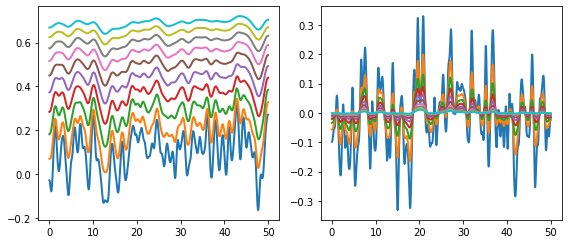

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def G(u, v, f, k): return f * (1 - u) - u*v**2 
def H(u, v, f, k): return -(f + k) * v + u*v**2

def gray_scott(y, t, f, k, Du, Dv, dx):
    u = y[::2]
    v = y[1::2]

    dydt = np.empty_like(y)
    dudt = dydt[::2]
    dvdt = dydt[1::2]

    dudt[0] = G(u[0], v[0], f, k) + Du*(-2*u[0] + 2*u[1])/dx**2
    dudt[1:-1] = G(u[1:-1], v[1:-1], f, k) + Du*np.diff(u,2)/dx**2
    dudt[-1] = G(u[-1], v[-1], f, k) + Du*(- 2*u[-1] + 2*u[-2])/dx**2

    dvdt[0] = H(u[0], v[0], f, k) + Dv*(-2*v[0] + 2*v[1])/dx**2
    dvdt[1:-1] = H(u[1:-1], v[1:-1], f, k) + Dv*np.diff(v,2)/dx**2
    dvdt[-1] = H(u[-1], v[-1], f, k) + Dv*(-2*v[-1] + 2*v[-2])/dx**2

    return dydt

xsize, tsize = 5000, 11
y0 = np.random.randn(xsize)
t = np.linspace(0, 50, tsize)
f = 0.024
k = 0.055
Du = 0.01
Dv = 0.005
dx = 0.025

x, dx = np.linspace(0, 50, int(y0.size/2), retstep=True)
y = odeint(gray_scott, y0, t, args=(f, k, Du, Dv, dx), ml=2, mu=2)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3.5))
# u, v = y[0,::2], y[0,1::2]
# ax1.plot(x, u, 'k:', lw=2)
# ax2.plot(x, v, 'k:', lw=2)
for k in range(t.size-1):
    u, v = y[k+1,::2], y[k+1,1::2]
    ax1.plot(x, u, lw=2)
    ax2.plot(x, v, lw=2)

fig.tight_layout()